In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode, when, lower, desc,count, mean, stddev, max, min, length, from_unixtime,to_date, dense_rank,  monotonically_increasing_id, regexp_replace, udf, first
from pyspark.sql.window import Window
from pyspark.ml.feature import MinHashLSH,HashingTF, Tokenizer, StopWordsRemover
from pyspark.sql.types import BooleanType, FloatType
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
from tabulate import tabulate
import numpy as np


# Define the base GCS path 
gcs_folder = 'gs://msca-bdp-data-open/final_project_git'

In [3]:
# Load cleaned datasets for intermediate use
clean_commits = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/commits_data")
flattened_languages = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/languages_data")
clean_files = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/files_data")
clean_licenses = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/licenses_data")
clean_contents = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/contents_data")

**3. Timeline Analysis on Commits**

In [7]:
# Convert author_time_sec to a readable timestamp
clean_commits = clean_commits.withColumn("commit_date", to_date(from_unixtime(col("author_time_sec"))))

# Group by date and count the number of commits per day
daily_commits = clean_commits.groupBy("commit_date").agg(count("*").alias("commit_count"))

# Convert to Pandas for easier plotting
daily_commits_pd = daily_commits.orderBy("commit_date").toPandas()

In [10]:
# Detect and remove outliers using IQR
q1 = daily_commits_pd["commit_count"].quantile(0.25)
q3 = daily_commits_pd["commit_count"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_commits_pd = daily_commits_pd[
    (daily_commits_pd["commit_count"] >= lower_bound) &
    (daily_commits_pd["commit_count"] <= upper_bound)
]

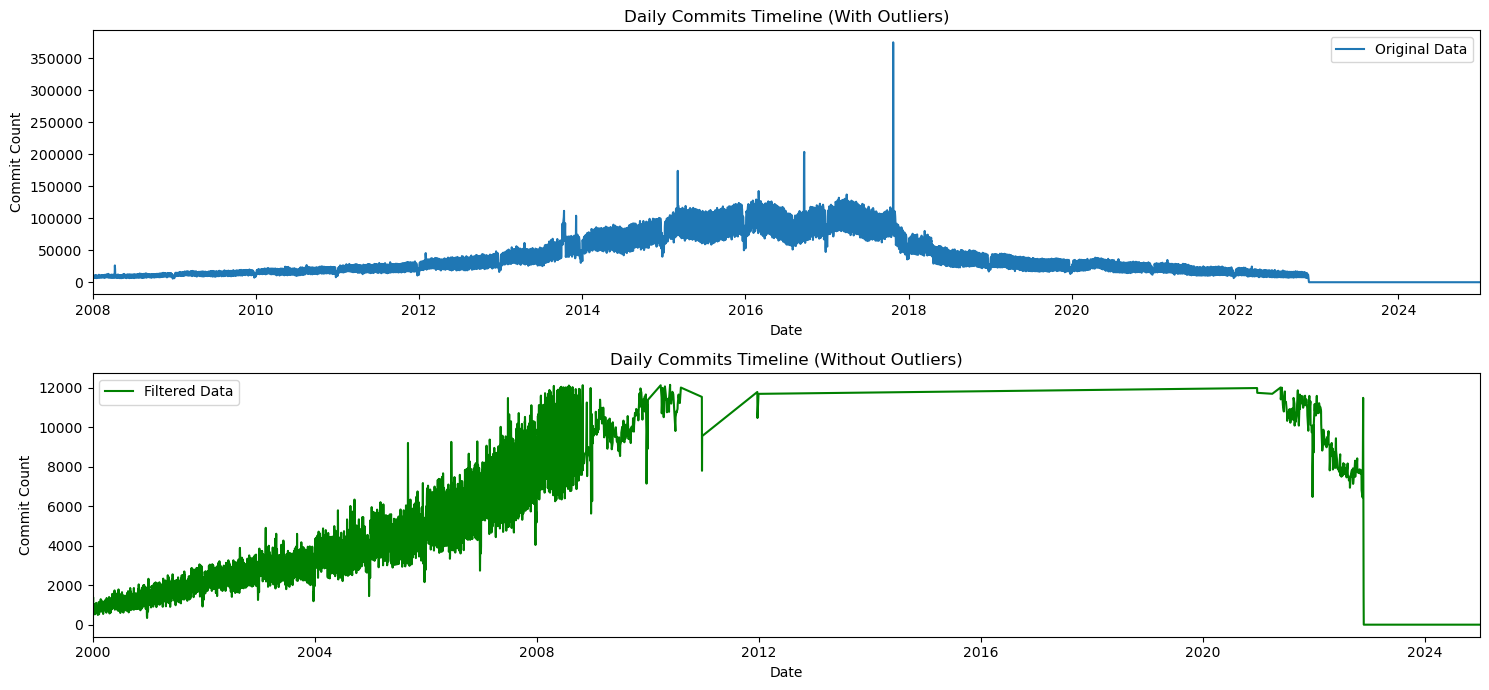

In [12]:
# Plot the timeline with and without outliers
plt.figure(figsize=(15, 7))

# Original data
plt.subplot(2, 1, 1)
plt.plot(daily_commits_pd["commit_date"], daily_commits_pd["commit_count"], label="Original Data")
plt.xlabel("Date")
plt.ylabel("Commit Count")
plt.title("Daily Commits Timeline (With Outliers)")
plt.legend()
plt.xlim(pd.Timestamp("2008-01-01"), pd.Timestamp("2024-12-31"))  #Start from Github inception

# Filtered data
plt.subplot(2, 1, 2)
plt.plot(filtered_commits_pd["commit_date"], filtered_commits_pd["commit_count"], label="Filtered Data", color="green")
plt.xlabel("Date")
plt.ylabel("Commit Count")
plt.title("Daily Commits Timeline (Without Outliers)")
plt.legend()
plt.xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2024-12-31"))

plt.tight_layout()
plt.show()

The timeline with outliers is more useful as the IQR method removes too many data points. I chose to include the sudden spikes in commits because these data points are valuable in this analysis. I will focus on these spikes in my next analysis.

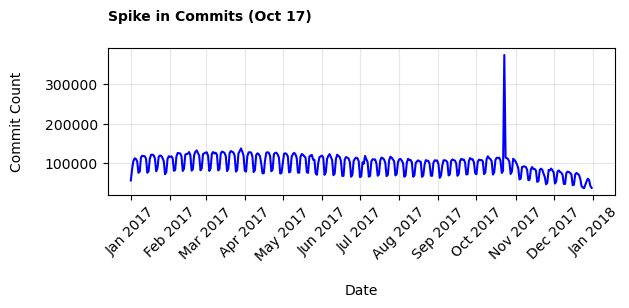

In [20]:
# Looking at the huge spike in October 2017

plt.subplot(2, 1, 2)
daily_commits_2017 = daily_commits_pd[
   (pd.to_datetime(daily_commits_pd['commit_date']).dt.year == 2017)
]
plt.plot(daily_commits_2017["commit_date"], daily_commits_2017["commit_count"], color='blue')
plt.xlabel("Date", labelpad=15)
plt.ylabel("Commit Count", labelpad=15)
plt.title("Spike in Commits (Oct 17)", fontsize=10, loc='left', pad=20, weight="bold")
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Github lists the top repositories and contributors on the Octoverse 2017 website, which shows that 2017 was an extremely active year for Github repositories. In addition, Github has Hacktoberfest every year, but in 2017, it had better promotion strategies, including partnerships with open-source communities and direct outreach to repositories. It saw unprecedented participation, with over 200,000 merged pull requests across nearly 65,000 repositories and involving almost 32,000 contributors worldwide.

**4. Most Popular Programming Languages**

In [4]:
# Explode `language_name` array for analysis
exploded_languages = flattened_languages.select(
    "repo_name",
    explode(col("language_name")).alias("exploded_language_name"),
    (col("language_bytes")).alias("exploded_language_bytes")
)

# Language Distribution
print("\nLanguage Distribution:")
exploded_languages.groupBy("exploded_language_name").count().orderBy(desc("count")).show(10)


Language Distribution:


+----------------------+-------+
|exploded_language_name|  count|
+----------------------+-------+
|            JavaScript|3941397|
|                   CSS|3452895|
|                  HTML|3355645|
|                 Shell|3155632|
|                Python|2238254|
|                     C|1804023|
|                   C++|1717426|
|              Makefile|1544946|
|                  Ruby|1348558|
|                   PHP|1300760|
+----------------------+-------+
only showing top 10 rows



In [8]:
# Extract year from existing commit_date and join with languages
language_by_year = clean_commits \
    .select(
        F.explode("repo_name").alias("repo_name"),
        F.year(F.col("commit_date")).alias("commit_year")
    ) \
    .join(exploded_languages, "repo_name")

# Calculate yearly distribution for top languages
yearly_distribution = language_by_year \
    .filter((F.col("commit_year") >= 2008) & (F.col("commit_year") <= 2024)) \
    .groupBy("commit_year", "exploded_language_name") \
    .count() \
    .withColumn(
        "percentage",
        F.round(F.col("count") * 100 / F.sum("count").over(Window.partitionBy("commit_year")), 2)
    ) \
    .filter(F.col("exploded_language_name").isin(
        "JavaScript", "CSS", "HTML", "Python", "Shell", 
        "C", "C++", "Ruby", "PHP", "Makefile"
    ))

In [ ]:
# Show results by total count
print("Yearly Language Distribution (By Total Count):")
yearly_distribution \
    .select("commit_year", "exploded_language_name", "count", "percentage") \
    .orderBy(F.desc("count")) \
    .show(20)

Yearly Language Distribution (By Total Count):


+-----------+----------------------+----------+----------+
|commit_year|exploded_language_name|     count|percentage|
+-----------+----------------------+----------+----------+
|       2011|                 Shell|5441665732|      6.02|
|       2011|                Python|5300359817|      5.87|
|       2011|                   C++|5217518563|      5.78|
|       2011|                     C|5185952529|      5.74|
|       2009|                 Shell|5154851206|      6.06|
|       2009|                Python|5068028480|      5.96|
|       2009|                     C|5059014340|      5.95|
|       2009|                   C++|5055508857|      5.95|
|       2010|                 Shell|5045132664|      6.02|
|       2010|                Python|4926763658|      5.87|
|       2010|                   C++|4875329424|      5.81|
|       2010|                     C|4841826766|      5.77|
|       2008|                 Shell|4738439539|      6.04|
|       2008|                Python|4683395339|      5.9

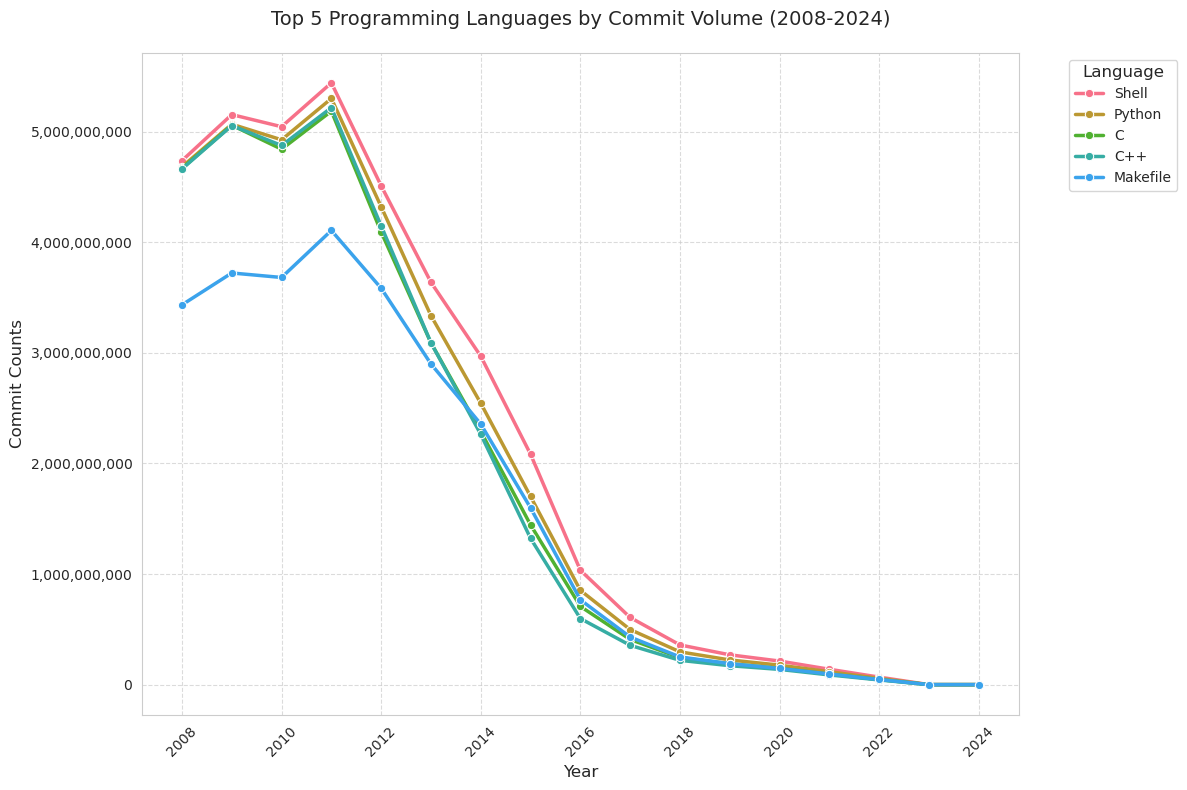

In [ ]:
# Convert to Pandas
lang_yr_df = yearly_distribution.select('commit_year', 'exploded_language_name', 'count').toPandas()

# Pivot the data 
df_pivot = lang_yr_df.pivot(index='commit_year', 
                    columns='exploded_language_name', 
                    values='count')

# Get top 5 languages by mean count
top_5_languages = df_pivot.mean().nlargest(5).index.tolist()

# Filter for only top 5 languages
df_plot = df_pivot[top_5_languages]

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Plot lines for each language
for language in top_5_languages:
    sns.lineplot(data=df_plot, 
                x=df_plot.index, 
                y=language, 
                label=language,
                linewidth=2.5,
                marker='o')

# Customize the plot
plt.title('Top 5 Programming Languages by Commit Volume (2008-2024)', 
          fontsize=14, 
          pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Commit Counts', fontsize=12)
plt.legend(title='Language', 
          title_fontsize=12, 
          fontsize=10, 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left')

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

**5. License Distribution**

In [25]:
# Overall license distribution
print("License Distribution:")
clean_licenses.groupBy("license") \
    .count() \
    .withColumn("percentage", F.round(F.col("count") * 100 / clean_licenses.count(), 2)) \
    .orderBy(F.desc("count")) \
    .show()

License Distribution:


+------------+-------+----------+
|     license|  count|percentage|
+------------+-------+----------+
|         mit|1696489|     51.01|
|  apache-2.0| 495134|     14.89|
|     gpl-2.0| 341505|     10.27|
|     gpl-3.0| 340407|     10.24|
|bsd-3-clause| 150701|      4.53|
|bsd-2-clause|  55221|      1.66|
|   unlicense|  46414|       1.4|
|    agpl-3.0|  41179|      1.24|
|    lgpl-3.0|  39839|       1.2|
|     cc0-1.0|  26807|      0.81|
|     epl-1.0|  24199|      0.73|
|    lgpl-2.1|  22637|      0.68|
|     mpl-2.0|  18832|      0.57|
|         isc|  17735|      0.53|
|artistic-2.0|   8535|      0.26|
+------------+-------+----------+



In [28]:
# Convert to Pandas
license_pd = clean_licenses.groupBy("license") \
   .count() \
   .withColumn("percentage", F.round(F.col("count") * 100 / clean_licenses.count(), 2)) \
   .orderBy(F.desc("count")) \
   .toPandas()

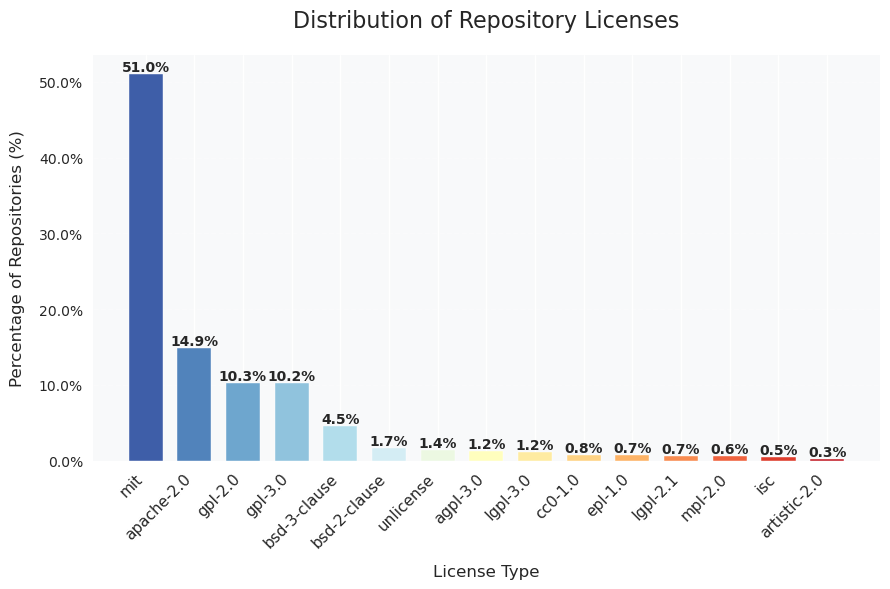

In [27]:
plt.style.use('seaborn')
plt.figure(figsize=(9, 6))

# Create color gradient
colors = sns.color_palette("RdYlBu_r", len(license_pd))

# Create the bar plot
bars = plt.bar(
    license_pd['license'],
    license_pd['percentage'],
    color=colors,
    width=0.7
)

# Add percentage labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.title('Distribution of Repository Licenses', 
          fontsize=16, 
          pad=20)
plt.xlabel('License Type', fontsize=12, labelpad=10)
plt.ylabel('Percentage of Repositories (%)', fontsize=12, labelpad=10)

# Format x-axis
plt.xticks(
    range(len(license_pd['license'])),
    license_pd['license'],
    rotation=45,
    ha='right',
    fontsize=11
)

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.gca().set_facecolor('#f8f9fa')

# Format y-axis to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))

plt.tight_layout()
plt.show()

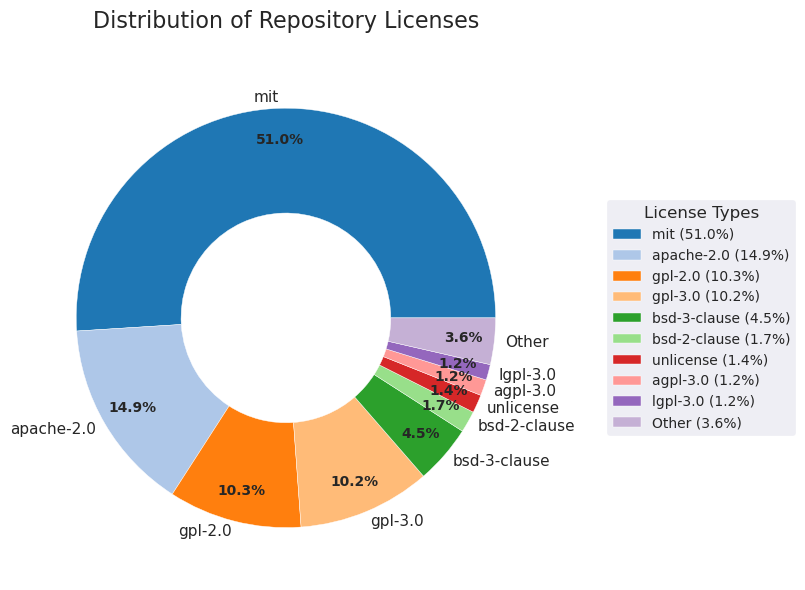

In [33]:
plt.style.use('seaborn')
plt.figure(figsize=(9, 6))

# Using bright distinct colors from tableau palette
colors = sns.color_palette("tab20", len(license_pd))

# Sort data by percentage for better visualization
license_pd_sorted = license_pd.sort_values('percentage', ascending=False)

# Only show labels for segments > 1% to reduce clutter
threshold = 1.0
major_licenses = license_pd_sorted[license_pd_sorted['percentage'] >= threshold]
minor_licenses = license_pd_sorted[license_pd_sorted['percentage'] < threshold]

# Combine small slices into "Other"
if len(minor_licenses) > 0:
    other_sum = minor_licenses['percentage'].sum()
    major_licenses = pd.concat([
        major_licenses,
        pd.DataFrame({
            'license': ['Other'],
            'percentage': [other_sum],
            'count': [minor_licenses['count'].sum()]
        })
    ])

# Create the pie chart
wedges, texts, autotexts = plt.pie(
    major_licenses['percentage'],
    labels=major_licenses['license'],
    colors=colors[:len(major_licenses)],
    autopct='%1.1f%%',
    pctdistance=0.85,
    wedgeprops=dict(width=0.5, edgecolor='white'),
    textprops={'fontsize': 11},
    labeldistance=1.05
)

# Enhance the appearance of percentage labels
plt.setp(autotexts, size=10, weight='bold')

plt.title('Distribution of Repository Licenses', 
          fontsize=16, 
          pad=20)

# Add a legend with percentages
plt.legend(
    wedges,
    [f"{license} ({pct:.1f}%)" 
     for license, pct in zip(major_licenses['license'], major_licenses['percentage'])],
    title="License Types",
    loc="center left",
    bbox_to_anchor=(1.1, 0, 0.5, 1),
    title_fontsize=12,
    fontsize=10,
    frameon=True,
    edgecolor='white'
)

# Adjust layout
plt.tight_layout()
plt.show()

In [34]:
# Join licenses with languages data
languages_licenses = clean_licenses.join(exploded_languages, "repo_name", how="inner")

# Show languages and licenses 
languages_licenses.show(5)

# Show language-license combinations ordered by count
print("\nTop Language-License Combinations:")
languages_licenses.groupBy("exploded_language_name", "license") \
    .count() \
    .orderBy(F.desc("count")) \
    .show(10)

+--------------------+-------+----------------------+-----------------------+
|           repo_name|license|exploded_language_name|exploded_language_bytes|
+--------------------+-------+----------------------+-----------------------+
|        0-0-1/cogbot|    mit|                Python|                [40997]|
|0-Eclipse-0/SaltB...|gpl-2.0|             Batchfile|                   [78]|
|0-Eclipse-0/Silve...|gpl-2.0|                   CSS|               [409011]|
|          0-mb/pg-lb|    mit|            JavaScript|                 [1092]|
|     0-mb/web-bundle|    mit|                    C#|   [17110, 1240, 446...|
+--------------------+-------+----------------------+-----------------------+
only showing top 5 rows


Top Language-License Combinations:


+----------------------+----------+-------+
|exploded_language_name|   license|  count|
+----------------------+----------+-------+
|            JavaScript|       mit|2042076|
|                   CSS|       mit|1718737|
|                  HTML|       mit|1674022|
|                 Shell|       mit| 981829|
|                  Ruby|       mit| 745254|
|                 Shell|   gpl-2.0| 691626|
|                Python|       mit| 643656|
|            JavaScript|apache-2.0| 577250|
|                  HTML|apache-2.0| 573732|
|                     C|   gpl-2.0| 557214|
+----------------------+----------+-------+
only showing top 10 rows



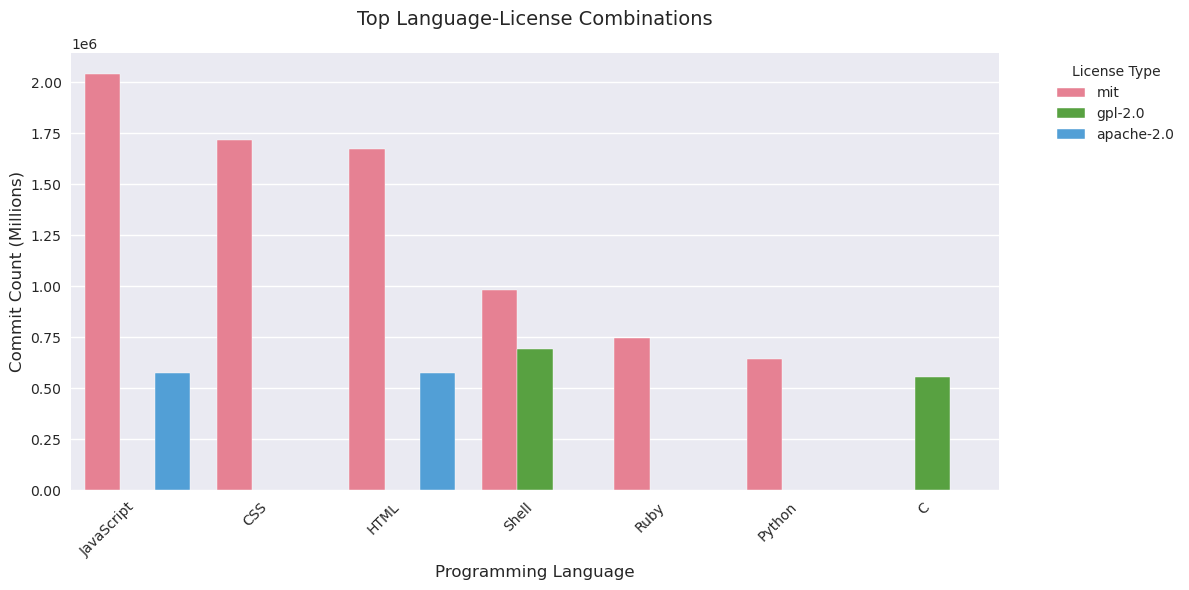

In [35]:
# Convert to pandas
language_license_counts = (
    languages_licenses.groupBy("exploded_language_name", "license")
    .count()
    .orderBy(F.desc("count"))
    .limit(10)
    .toPandas()
)

# Bar chart of top language-license combinations
plt.figure(figsize=(12, 6))
sns.barplot(
    data=language_license_counts,
    x='exploded_language_name',
    y='count',
    hue='license',
    palette='husl'
)

plt.title('Top Language-License Combinations', fontsize=14, pad=20)
plt.xlabel('Programming Language', fontsize=12)
plt.ylabel('Commit Count (Millions)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='License Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

JavaScript is widely used for web development and open-source projects because it’s versatile, easy to use, and has a huge ecosystem (e.g., frameworks like React, Node.js). The MIT license, commonly associated with JavaScript projects, is very permissive. It allows developers to freely use, modify, and distribute code with minimal restrictions, making it appealing for collaborative, fast-paced development environments.

C is heavily used in system-level projects like operating systems and embedded systems because it provides fine control over hardware and memory. The GPL-2.0 license is often preferred in these projects because it enforces copyleft principles, which means that anyone who modifies and redistributes the code must share their changes under the same license. This ensures that improvements to foundational software (e.g., the Linux kernel) remain accessible to the community.

Shell programming is often used for scripting and automating tasks in diverse environments. These scripts interact with various tools and systems, which makes them widely applicable. Due to this versatility, shell scripts are found in projects with different licensing needs. For projects that prioritize permissiveness and ease of sharing, the MIT license is used.For projects that emphasize community-driven improvements and enforce code-sharing, GPL-2.0 is appropriate. This variety of use cases leads to a more balanced distribution across licenses compared to other languages. 

**6. Most Popular and Rapidly Growing Repositories**

In [6]:
#Filtering commits to only include repository name
repo_commits = clean_commits.select("repo_name")

# Most popular repositories
repo_commits.groupBy("repo_name") \
    .count() \
    .orderBy(F.desc("count")) \
    .show(10)

+--------------------+-------+
|           repo_name|  count|
+--------------------+-------+
| [shenzhouzd/update]|1188563|
|[duaneking/rockst...| 597893|
|[spiderworthy/linux]| 495786|
|[chromium/chromiu...| 396321|
|[curtclifton/curt...| 384809|
|[JurassicWordExce...| 353165|
|[cloudfoundry/rel...| 339252|
|[smaslennikov/wha...| 286895|
| [miatribe/pipvpspy]| 279811|
|[IonicaBizau/I-Lo...| 263179|
+--------------------+-------+
only showing top 10 rows



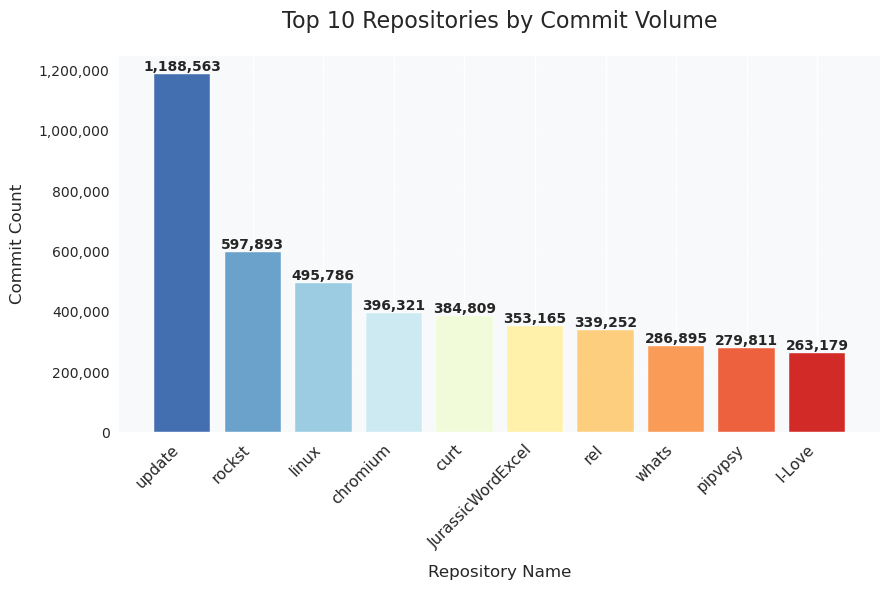

In [24]:
# Top 10 repositories by commit volume

top_repos = ['shenzhouzd/update', 'duaneking/rockst', 'spiderworthy/linux', 'chromium/chromium', 
             'curtclifton/curt', 'JurassicWordExcel', 'cloudfoundry/rel', 'smaslennikov/whats', 'miatribe/pipvpsy',
             'IonicaBizau/I-Love'] 

commit_counts = [1188563,597893, 495786, 396321, 384809, 353165, 339252, 286895, 279811, 263179]

plt.style.use('seaborn')
plt.figure(figsize=(9,6))

# Create color gradient for bars
colors = sns.color_palette("RdYlBu_r", len(top_repos))

# Create the bar plot
bars = plt.bar(range(len(top_repos)), commit_counts, color=colors)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height):,}',  # Format with comma separators
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        rotation=0
    )

plt.title('Top 10 Repositories by Commit Volume', 
          fontsize=16, 
          pad=20)
plt.xlabel('Repository Name', fontsize=12, labelpad=10)
plt.ylabel('Commit Count', fontsize=12, labelpad=10)

# Format x-axis
plt.xticks(
    range(len(top_repos)), 
    [repo.split('/')[-1] for repo in top_repos],  
    rotation=45,
    ha='right',
    fontsize=11
)

# Format y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add a light background color to highlight the data area
plt.gca().set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

**Are there certain technologies that are driving popularity or explosive growth?**

Docker-related technology appears prominent, with "duaneking/rockst" showing the second-highest commit activity. This reflects the continued strong growth and adoption of containerization technologies. Linux related technologies are also extremely popular, as shown by "spiderworthy/linux." Web browser technologies are almost as prominent; Chromium (an open-source project behind Chrome OS and Chrome browser) draws sustained attention, which requires constant updating. Ultimately, these updates contribute to high commit count. 

The overall patterns show that core development tools receive the most sustained attention, rather than seeing explosive growth in newer technologies. This suggests a mature ecosystem where fundamental technologies continue to evolve and improve rather than being displaced by new alternatives. 

**Are these associated with Big Tech, who are open sourcing the technology?**

Since Chromium is a project by Chrome, it is directly associated with Google. Its high commit activity (~396K commits) reflects Google's significant investment in web technologies.

However, interestingly, most of the other top repositories don't seem to be associated with Big Tech. While linux is used extensively by Big Tech companies, this development is community-driven. Additionally, Curl is an independent open-source project, not affiliated with Big Tech.

**Are there any technological breakthroughs that are driving this brisk adoption?**

The first thing I noticed was the high activity in the Docker-related repository ("duaneking/rockst"). This suggests that containerization has had a breakthrough impact because it enables consistent development environments and easier cloud deployment. 

Chromium's high commit count is also indicative of a shift towards browser-based applications. Chromium is optimized more efficiently than ever, and its popularity is reflective of it. 


**7. Technologies Most Associated with Data Science and AI Projects**

In [7]:
# Sample commits with just repo_name
repo_commits_sample = repo_commits.sample(0.001, False, 42)

In [8]:
# Only include repositories with "Data Science" or "AI" in the text
ai_data = ["Data Science", "Artificial Intelligence", "AI"]

ai_data_repos = (
    repo_commits_sample
    .filter(
        F.lower(F.col("repo_name")[0]).rlike('.*(' + '|'.join(ai_data).lower().replace(' ', '[-_\\s]') + ').*')
    )
    .distinct()
)

ai_data_repos.show(5)

+--------------------+
|           repo_name|
+--------------------+
|[nblair/uw-frame,...|
|[caiodias/Cleaner...|
|[Ajapaik/ajapaik-...|
|[ChairGraveyard/G...|
|[juliatem/aiohttp...|
+--------------------+
only showing top 5 rows



In [9]:
# Top 10 languages associated with Data Science or AI
ai_data_languages = (
    ai_data_repos
    .select(F.col("repo_name")[0].alias("repo_name")) 
    .join(exploded_languages, on="repo_name", how="inner")
    .groupBy("exploded_language_name")
    .count()
    .orderBy(F.desc("count"))
)

ai_data_languages.show(10)

+----------------------+-----+
|exploded_language_name|count|
+----------------------+-----+
|                 Shell|15560|
|            JavaScript|14905|
|                  HTML|13875|
|                   CSS|13805|
|                Python|10839|
|              Makefile| 7993|
|                     C| 7909|
|                   C++| 7435|
|                  Ruby| 5914|
|                  Java| 5459|
+----------------------+-----+
only showing top 10 rows



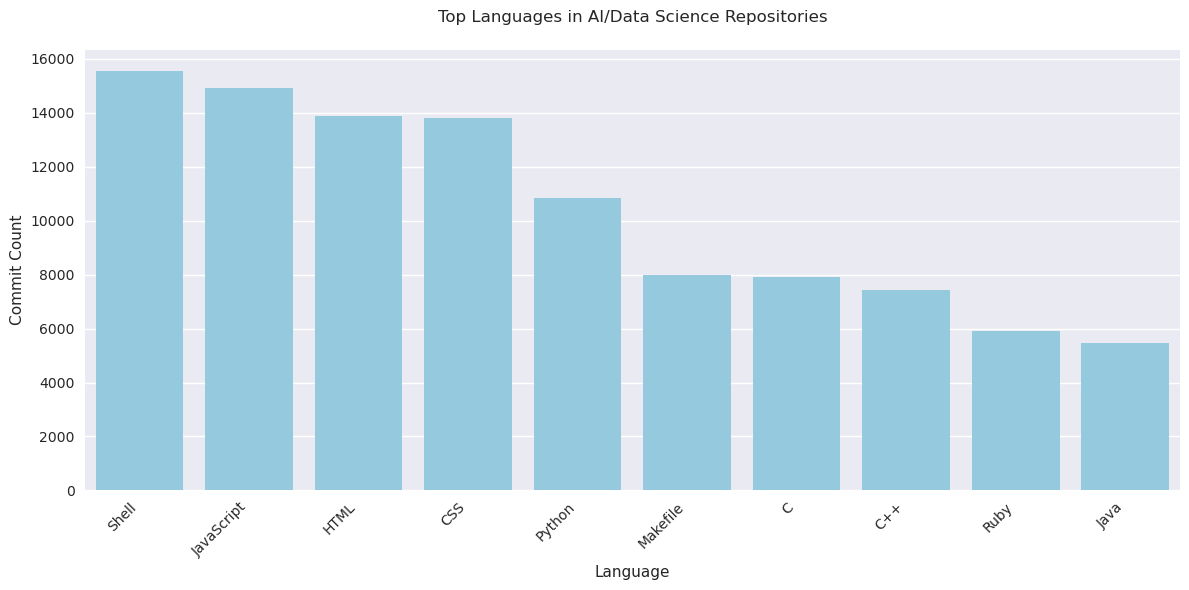

In [19]:
top_ai_data = ai_data_languages.limit(10).toPandas()

plt.style.use('seaborn')
plt.figure(figsize=(12, 6))

# Bar chart showing top 10 languages associated with Data Science or AI
sns.barplot(data=top_ai_data, 
            x='exploded_language_name', 
            y='count',
            color='skyblue')

plt.title('Top Languages in AI/Data Science Repositories', pad=20)
plt.xlabel('Language')
plt.ylabel('Commit Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
clean_commits_fixed = clean_commits.select(
    F.col("repo_name")[0].alias("repo_name_str"),
    "commit_date")

# Calculate yearly trends 
yearly_ai_trends = (
    ai_data_repos
    .select(F.col("repo_name")[0].alias("repo_name_str"))
    .join(clean_commits_fixed, on="repo_name_str", how="inner")
    .join(
        exploded_languages.select(
            "repo_name",  # already a string
            "exploded_language_name"), 
        exploded_languages.repo_name == F.col("repo_name_str"),  # explicit join condition
        how="inner")
    .withColumn("year", F.year("commit_date"))
    .filter((F.col("year") >= 2008) & (F.col("year") <= 2024)) # Filter for between 2008-2024
    .groupBy("year", "exploded_language_name")
    .count()
    .orderBy("year", F.desc("count"))
)

yearly_ai_trends.show(10)

+----+----------------------+-------+
|year|exploded_language_name|  count|
+----+----------------------+-------+
|2008|                 Shell|2185434|
|2008|            JavaScript|1571254|
|2008|                   CSS|1536811|
|2008|                Python|1505001|
|2008|                  HTML|1478118|
|2008|                  Perl|1235114|
|2008|                  Ruby|1175622|
|2008|                  XSLT|1137891|
|2008|                   C++|1121295|
|2008|                     C|1114661|
+----+----------------------+-------+
only showing top 10 rows



<Figure size 1500x800 with 0 Axes>

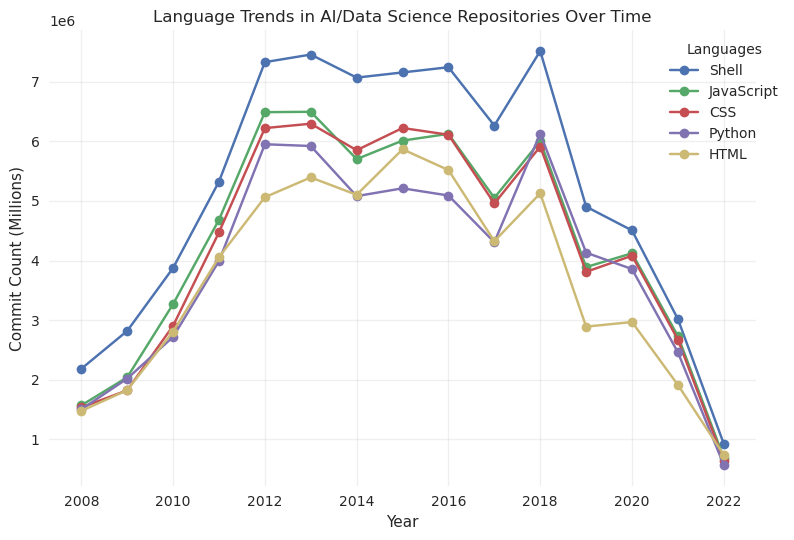

In [21]:
trends_pd = yearly_ai_trends.toPandas()

# Create pivot table 
pivot_data = trends_pd.pivot(index='year', 
                           columns='exploded_language_name', 
                           values='count')

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Get top 5 languages by total commits
top_languages = (
    trends_pd.groupby('exploded_language_name')['count']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Plot only top 5 languages for clarity
pivot_data[top_languages].plot(kind='line', marker='o')
plt.title('Language Trends in AI/Data Science Repositories Over Time')
plt.xlabel('Year')
plt.ylabel('Commit Count (Millions)')
plt.legend(title='Languages', bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**8. Most Frequent Reasons for Committing**

In [5]:
message_sample = clean_commits.select('message').sample(0.001, False, 42)

In [6]:
message_sample.show(5)

+--------------------+
|             message|
+--------------------+
|* first attempt t...|
|A reference to th...|
|Merged HEAD-BUG-F...|
|   Add appveyor.yml
|
|dalsze psucie  ht...|
+--------------------+
only showing top 5 rows



In [10]:
def analyze_commit_purpose(message):
    """
    Analyzes the fundamental purpose of GitHub commits
    Focuses on primary reasons for development activities
    """
    message = message.lower()
    
    # New Technology/Feature Development
    if any(word in message for word in ["add", "new", "feature", "create", "implement", "initial"]):
        return "New Development"
    
    # Bug Fixes and Problem Resolution
    elif any(word in message for word in ["fix", "bug", "issue", "error", "crash", "resolve", "patch"]):
        return "Bug Resolution"
    
    # Enhancement of Existing Features
    elif any(word in message for word in ["improve", "update", "enhance", "upgrade", "optimize", "refactor"]):
        return "Enhancement"
    
    # Technical Maintenance
    elif any(word in message for word in ["maintain", "dependency", "version", "package", "library", "bump"]):
        return "Maintenance"
    
    # Project Support/Documentation
    elif any(word in message for word in ["doc", "readme", "comment", "license", "example"]):
        return "Documentation"
    
    # Integration and Collaboration
    elif any(word in message for word in ["merge", "sync", "integrate", "collaboration", "branch"]):
        return "Integration"
    
    # Testing and Validation
    elif any(word in message for word in ["test", "check", "validate", "verify", "coverage", "qa"]):
        return "Testing"
    
    # Everything else
    else:
        return "Other Changes"

# Apply the analysis to the sample
commit_analysis = message_sample.withColumn(
    "commit_purpose", 
    F.udf(analyze_commit_purpose)(F.col("message"))
)

# Get total count
total_commits = commit_analysis.count()

# Calculate distribution
purpose_distribution = commit_analysis.groupBy("commit_purpose") \
    .count() \
    .withColumn("percentage", 
                F.round(F.col("count") * 100 / total_commits, 2)) \
    .orderBy(F.col("count").desc())

# Show results
purpose_distribution.show(truncate=False)

+---------------+-----+----------+
|commit_purpose |count|percentage|
+---------------+-----+----------+
|Other Changes  |80218|31.75     |
|New Development|65537|25.94     |
|Bug Resolution |40971|16.22     |
|Enhancement    |32182|12.74     |
|Integration    |14204|5.62      |
|Maintenance    |7031 |2.78      |
|Testing        |6960 |2.76      |
|Documentation  |5520 |2.19      |
+---------------+-----+----------+



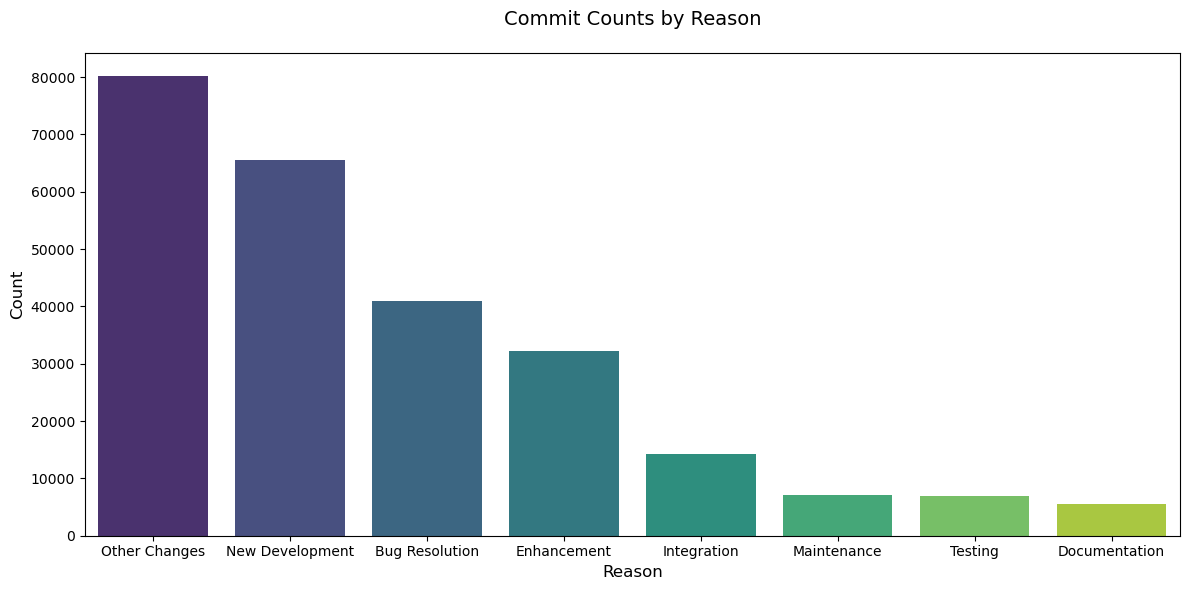

In [29]:
commit_reasons = ['Other Changes', 'New Development', 'Bug Resolution', 'Enhancement', 'Integration', 
                  'Maintenance', 'Testing', 'Documentation']

commit_reason_counts = [80218, 65537, 40971, 32182, 14204, 7031, 6960, 5520]

# Bar Chart of commit counts by reason
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=commit_reasons, 
                      y=commit_reason_counts, 
                      palette='viridis')

plt.title('Commit Counts by Reason', pad=20, size=14)
plt.xlabel('Reason', size=12)
plt.ylabel('Count', size=12)
plt.tight_layout()
plt.show()

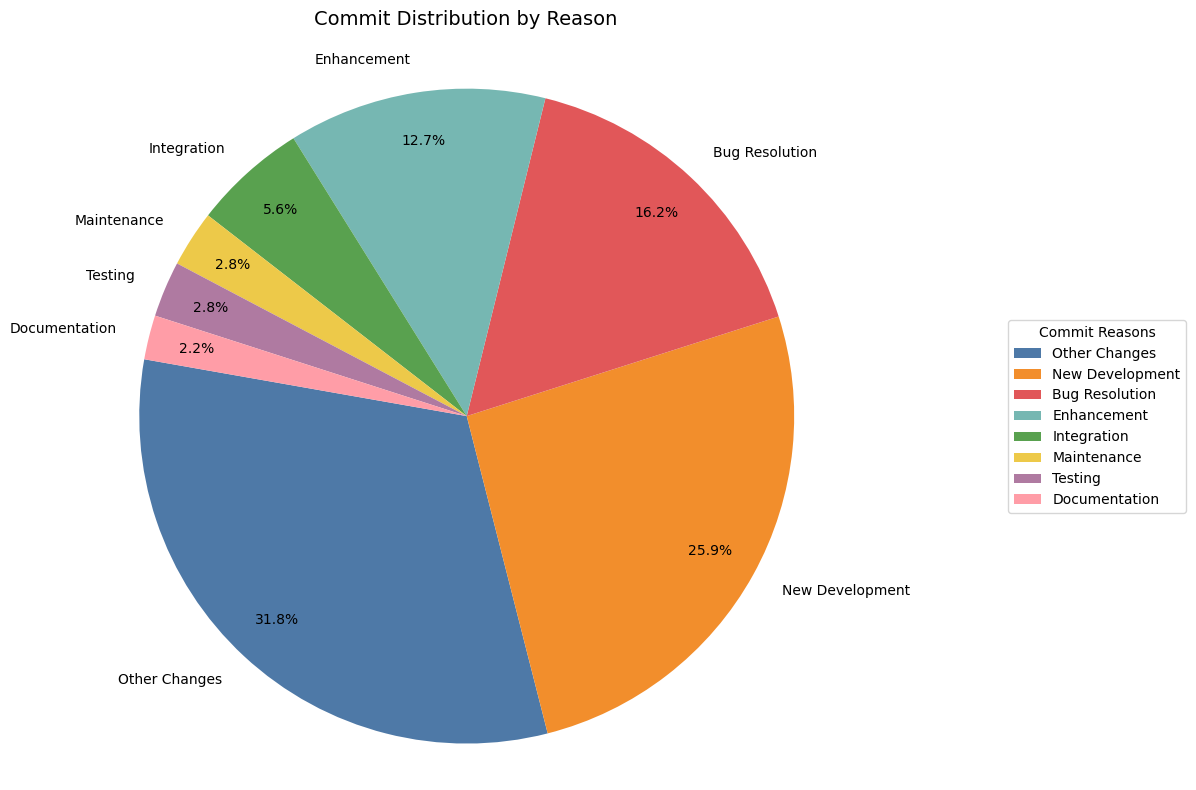

In [21]:
# Custom color palette
colors = ['#4e79a7',    # Blue
          '#f28e2c',    # Orange
          '#e15759',    # Red
          '#76b7b2',    # Teal
          '#59a14f',    # Green
          '#edc949',    # Yellow
          '#af7aa1',    # Purple
          '#ff9da7']    # Pink

# Pie chart of commit counts by reason
plt.figure(figsize=(12, 8))
plt.pie(commit_reason_counts, 
        labels=commit_reasons,
        autopct='%1.1f%%',
        startangle=170,
        labeldistance=1.1,
        pctdistance=0.85,
        colors=colors)

plt.title('Commit Distribution by Reason', pad=20, size=14)

plt.legend(commit_reasons, 
          title="Commit Reasons",
          loc="center left",
          bbox_to_anchor=(1.1, 0, 0.5, 1))

plt.axis('equal')
plt.tight_layout()
plt.show()

**9. Most Prolific/Influential Committers**

In [23]:
# Find top committers by author name
clean_commits.groupBy("author_name").count().orderBy("count", ascending=False).show(20)

+--------------------+-------+
|         author_name|  count|
+--------------------+-------+
|          shenzhouzd|1188430|
|       Duane F. King| 597940|
|  Marge Spiderworthy| 495786|
|        Curt Clifton| 384915|
|James Michael DuPont| 343258|
|    CI Pool Resource| 316075|
|             unknown| 305814|
|                time| 286933|
|          miatribepi| 279802|
|             Jenkins| 279285|
|Matthew Weier O'P...| 265480|
|           aatchison| 262278|
|                root| 230068|
|conda-forge-coord...| 210039|
|                test| 189078|
|             Emile B| 187684|
|                keum| 186686|
|        Ionică Bizău| 184417|
|               chous| 167515|
|Bactrian the Two-...| 165324|
+--------------------+-------+
only showing top 20 rows



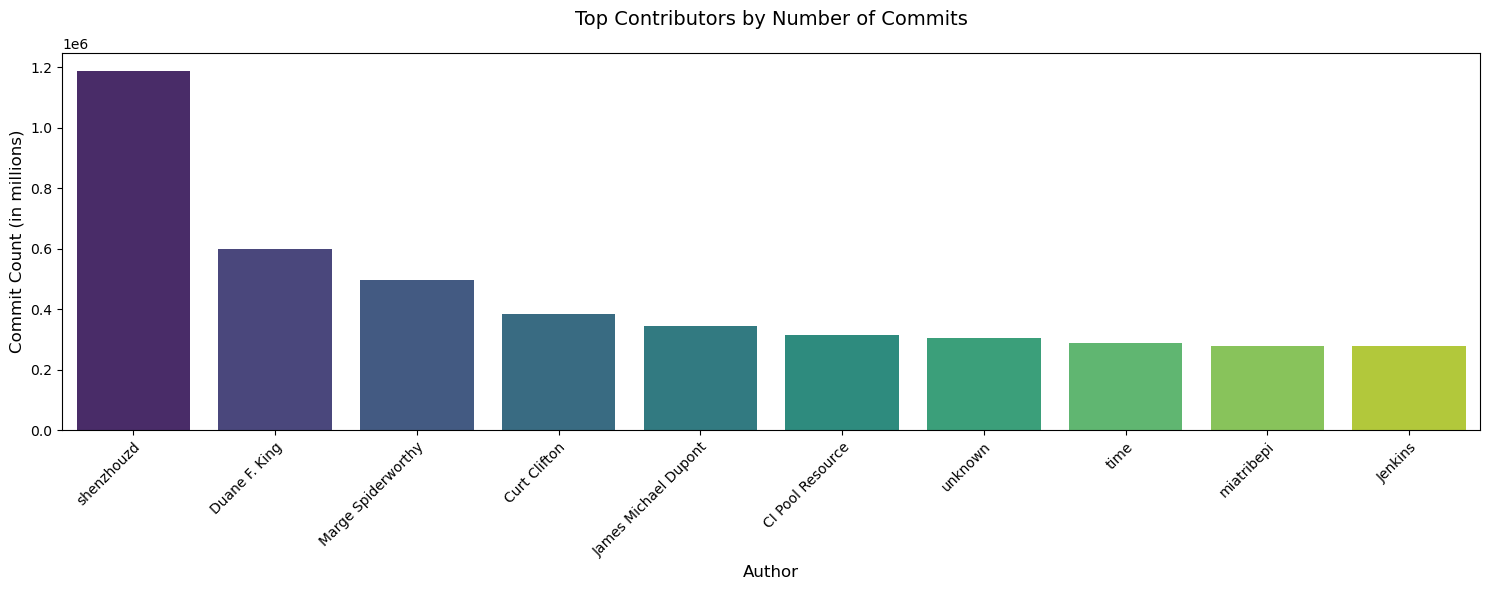

In [30]:
# Bar chart of top authors
top_author_names = ['shenzhouzd', 'Duane F. King', 'Marge Spiderworthy', 'Curt Clifton',
                   'James Michael Dupont', 'CI Pool Resource', 'unknown', 'time', 'miatribepi',
                   'Jenkins']

top_author_counts = [1188430, 597940, 495786, 384915, 343258, 316075, 305814, 286933, 279802, 279285]

# Bar plot of top committers
plt.figure(figsize=(15, 6))
bar_plot = sns.barplot(x = top_author_names,
                      y= top_author_counts,
                      palette='viridis')
plt.xticks(rotation=45,        
           ha='right',         
           rotation_mode='anchor')

plt.title('Top Contributors by Number of Commits', pad=20, size=14)
plt.xlabel('Author', size=12)
plt.ylabel('Commit Count (in millions)', size=12)
plt.tight_layout()
plt.show()


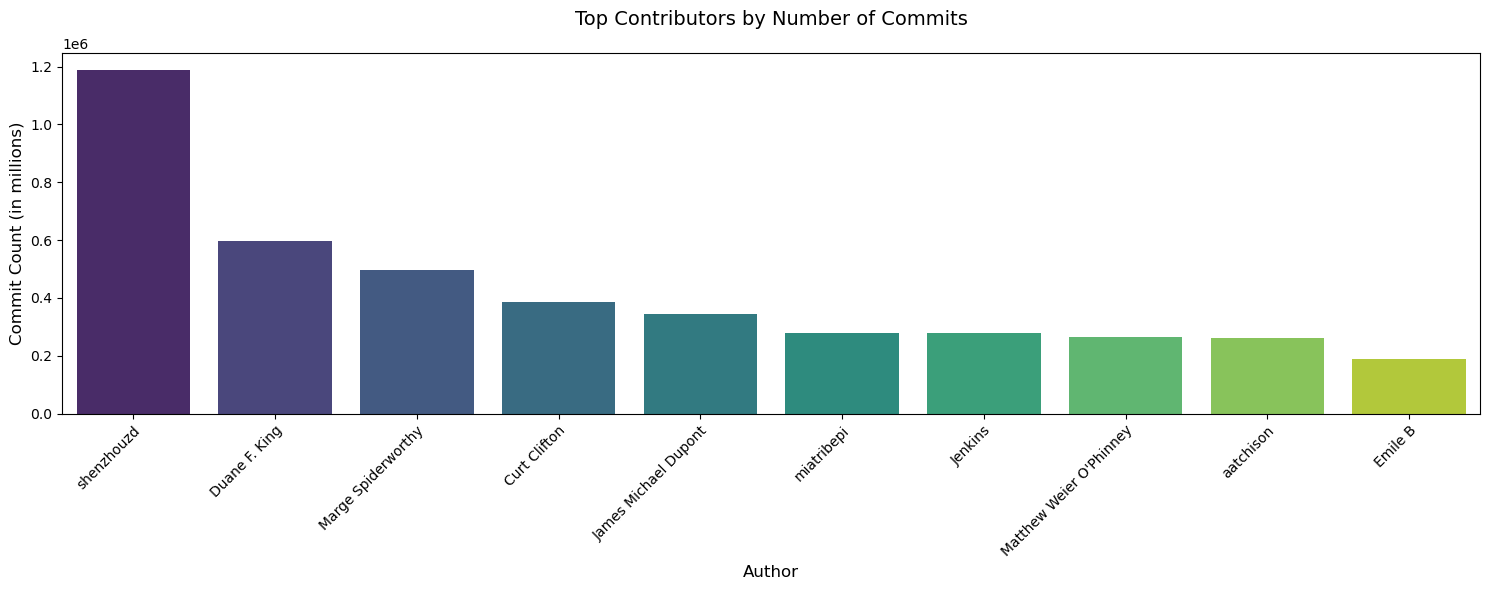

In [31]:
# Remove system/service accounts and organization accounts
# Focus on human authors

filtered_top_authors = ['shenzhouzd', 'Duane F. King', 'Marge Spiderworthy', 'Curt Clifton',
                        'James Michael Dupont', 'miatribepi', 'Jenkins', "Matthew Weier O'Phinney",
                        'aatchison', 'Emile B']
                        

filtered_top_author_count = [1188430, 597940, 495786, 384915, 343258, 279802, 279285, 265480, 262278,187684]

# Bar plot of top authors that aren't bots
plt.figure(figsize=(15, 6))
bar_plot = sns.barplot(x = filtered_top_authors,
                      y= filtered_top_author_count,
                      palette='viridis')
plt.xticks(rotation=45,        
           ha='right',         
           rotation_mode='anchor')

plt.title('Top Contributors by Number of Commits', pad=20, size=14)
plt.xlabel('Author', size=12)
plt.ylabel('Commit Count (in millions)', size=12)
plt.tight_layout()
plt.show()


**10. Uniqueness of Subject and Message Values**

In [5]:
# Sample commits with subject and message values
subject_message_sample = clean_commits.select("repo_name", "subject", "message").sample(0.001, False, 42)

In [4]:
subject_message_sample.show(5)

+--------------------+--------------------+--------------------+
|           repo_name|             subject|             message|
+--------------------+--------------------+--------------------+
|[ocpyosep78/forkc...|* first attempt t...|* first attempt t...|
|[GPUOpen-Drivers/...|A reference to th...|A reference to th...|
|[Alfresco/alfresc...|Merged HEAD-BUG-F...|Merged HEAD-BUG-F...|
|[digidem/ecuador-...|    Add appveyor.yml|   Add appveyor.yml
|
|  [porridge/libgadu]|dalsze psucie  ht...|dalsze psucie  ht...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [6]:
# Remove puncutation and break down messages and subjects into words
clean_sm_sample = subject_message_sample.withColumn(
    "clean_message",
    lower(regexp_replace(col("message"), "[^a-zA-Z0-9\\s]", ""))
)

clean_sm_sample = clean_sm_sample.withColumn(
   "clean_subject",
   F.lower(F.regexp_replace(F.col("subject"), "[^a-zA-Z0-9\\s]", ""))
)

In [6]:
clean_sm_sample.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|           repo_name|             subject|             message|       clean_message|       clean_subject|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|[ocpyosep78/forkc...|* first attempt t...|* first attempt t...| first attempt to...| first attempt to...|
|[GPUOpen-Drivers/...|A reference to th...|A reference to th...|a reference to th...|a reference to th...|
|[Alfresco/alfresc...|Merged HEAD-BUG-F...|Merged HEAD-BUG-F...|merged headbugfix...|merged headbugfix...|
|[digidem/ecuador-...|    Add appveyor.yml|   Add appveyor.yml
|    add appveyoryml
|     add appveyoryml|
|  [porridge/libgadu]|dalsze psucie  ht...|dalsze psucie  ht...|dalsze psucie  ht...|dalsze psucie  ht...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [7]:
# Add message ids for each row
filtered_sm_sample = clean_sm_sample.withColumn("message_id", monotonically_increasing_id())

filtered_sm_sample = filtered_sm_sample.select("repo_name","message_id", "clean_message", "clean_subject")
filtered_sm_sample.show(5)

+--------------------+----------+--------------------+--------------------+
|           repo_name|message_id|       clean_message|       clean_subject|
+--------------------+----------+--------------------+--------------------+
|[ocpyosep78/forkc...|         0| first attempt to...| first attempt to...|
|[GPUOpen-Drivers/...|         1|a reference to th...|a reference to th...|
|[Alfresco/alfresc...|         2|merged headbugfix...|merged headbugfix...|
|[digidem/ecuador-...|         3|    add appveyoryml
|     add appveyoryml|
|  [porridge/libgadu]|         4|dalsze psucie  ht...|dalsze psucie  ht...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows



In [8]:
# Perform Tokenizer on messages
tokenizer = Tokenizer(inputCol="clean_message", outputCol="filtered_message")
filtered_sm_sample = tokenizer.transform(filtered_sm_sample)

# Perform Tokenizer on subjects
tokenizer = Tokenizer(inputCol="clean_subject", outputCol="filtered_subject")
filtered_sm_sample = tokenizer.transform(filtered_sm_sample)

filtered_sm_sample.select("repo_name","message_id", "clean_message","filtered_message", "filtered_subject").show(5)

+--------------------+----------+--------------------+--------------------+--------------------+
|           repo_name|message_id|       clean_message|    filtered_message|    filtered_subject|
+--------------------+----------+--------------------+--------------------+--------------------+
|[ocpyosep78/forkc...|         0| first attempt to...|[, first, attempt...|[, first, attempt...|
|[GPUOpen-Drivers/...|         1|a reference to th...|[a, reference, to...|[a, reference, to...|
|[Alfresco/alfresc...|         2|merged headbugfix...|[merged, headbugf...|[merged, headbugf...|
|[digidem/ecuador-...|         3|    add appveyoryml
|  [add, appveyoryml]|  [add, appveyoryml]|
|  [porridge/libgadu]|         4|dalsze psucie  ht...|[dalsze, psucie, ...|[dalsze, psucie, ...|
+--------------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [9]:
number_features = 500

# HashingTF for feature engineering
hashingTF = HashingTF(inputCol="filtered_message", outputCol="message_features", numFeatures=number_features)
filtered_sm_sample = hashingTF.transform(filtered_sm_sample)

hashingTF = HashingTF(inputCol="filtered_subject", outputCol="subject_features", numFeatures=number_features)
filtered_sm_sample = hashingTF.transform(filtered_sm_sample)

# Show feature vectors
filtered_sm_sample.select("repo_name","message_id", "message_features", "subject_features").show(5)

+--------------------+----------+--------------------+--------------------+
|           repo_name|message_id|    message_features|    subject_features|
+--------------------+----------+--------------------+--------------------+
|[ocpyosep78/forkc...|         0|(500,[17,22,57,92...|(500,[17,57,92,10...|
|[GPUOpen-Drivers/...|         1|(500,[15,17,54,76...|(500,[15,17,54,76...|
|[Alfresco/alfresc...|         2|(500,[17,39,56,64...|(500,[17,39,56,64...|
|[digidem/ecuador-...|         3|(500,[369,387],[1...|(500,[369,387],[1...|
|  [porridge/libgadu]|         4|(500,[24,165,246,...|(500,[24,165,246,...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows



In [10]:
# Apply MinHashLSH to message features
message_minhash = MinHashLSH(inputCol="message_features", outputCol="message_hashes", numHashTables=5)
message_model = message_minhash.fit(filtered_sm_sample)
filtered_sm_sample = message_model.transform(filtered_sm_sample)

# Apply MinHashLSH to subject features
subject_minhash = MinHashLSH(inputCol="subject_features", outputCol="subject_hashes", numHashTables=5)
subject_model = subject_minhash.fit(filtered_sm_sample)
filtered_sm_sample = subject_model.transform(filtered_sm_sample)

In [11]:
filtered_sm_sample.select("repo_name","message_id", "message_hashes","subject_hashes", "message_features", "subject_features").show(5)

+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|           repo_name|message_id|      message_hashes|      subject_hashes|    message_features|    subject_features|
+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|[ocpyosep78/forkc...|         0|[[1.13039686E8], ...|[[2.99236534E8], ...|(500,[17,22,57,92...|(500,[17,57,92,10...|
|[GPUOpen-Drivers/...|         1|[[1.8678956E7], [...|[[1.8678956E7], [...|(500,[15,17,54,76...|(500,[15,17,54,76...|
|[Alfresco/alfresc...|         2|[[2027525.0], [2....|[[2027525.0], [1....|(500,[17,39,56,64...|(500,[17,39,56,64...|
|[digidem/ecuador-...|         3|[[5.27315207E8], ...|[[5.27315207E8], ...|(500,[369,387],[1...|(500,[369,387],[1...|
|  [porridge/libgadu]|         4|[[1.42306314E8], ...|[[2.61390943E8], ...|(500,[24,165,246,...|(500,[24,165,246,...|
+--------------------+----------+--------------------+--

In [12]:
# Create UDF for jaccard similarity (Approxsimilarityjoin kept giving zero vectors)

def jaccard_similarity(vec1, vec2):
   # Convert vectors to sets
   set1 = set([i for i, v in enumerate(vec1) if v != 0])
   set2 = set([i for i, v in enumerate(vec2) if v != 0])
   
   # Calculate intersection and union
   intersection = len(set1.intersection(set2))
   union = len(set1.union(set2))
   
   # Return similarity
   return float(intersection) / union if union > 0 else 0.0

jaccard_similarity_udf = F.udf(jaccard_similarity)

similarity_sample = (
    filtered_sm_sample.withColumn(
        "jaccard_similarity",
        jaccard_similarity_udf(col("message_features"), col("subject_features"))
    )
)

# Set threshold and add jaccard distance column 
jaccard_threshold = 0.7
duplicates = (
    similarity_sample.
    withColumn(
        'distCol', 
        1 - col('jaccard_similarity')
    ).
    filter(col('distCol') < jaccard_threshold).
    count()
)

In [13]:
# Calculate unique items count
total_count = filtered_sm_sample.count()
unique = total_count - duplicates
print("Uniques:", unique)
print("Similar/Duplicates:", duplicates)

# Prepare DF
similarity_pd = pd.DataFrame({
    'Category': ['Unique', 'Similar'],
    'Count': [unique, duplicates]
})

Uniques: 21497
Similar/Duplicates: 231126


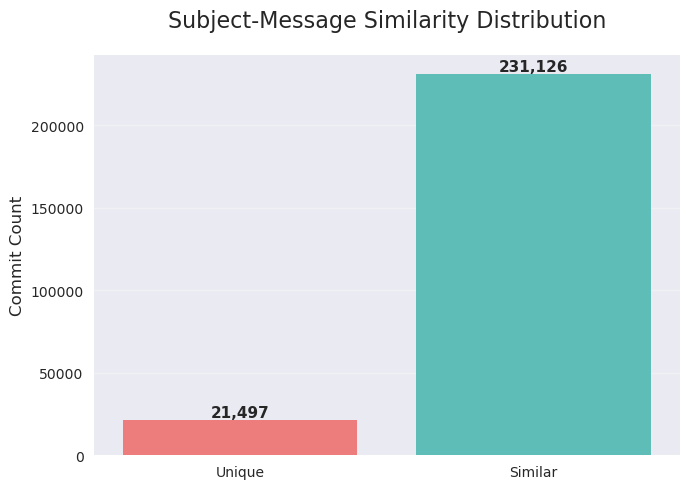

In [37]:
plt.style.use('seaborn')
sns.set_palette("deep")

# Create figure 
plt.figure(figsize=(7, 5))

# Create the bar chart
bars = sns.barplot(
    x='Category', 
    y='Count', 
    data=similarity_pd, 
    palette=['#FF6B6B', '#4ECDC4']  # Coral red and turquoise
)

# Add value labels on top of each bar
for i, bar in enumerate(bars.patches):
    bars.text(
        bar.get_x() + bar.get_width()/2.,
        bar.get_height(),
        f'{int(bar.get_height()):,}', 
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

plt.title('Subject-Message Similarity Distribution', fontsize=16, pad=20)
plt.ylabel('Commit Count', fontsize=12)
plt.xlabel('')  
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

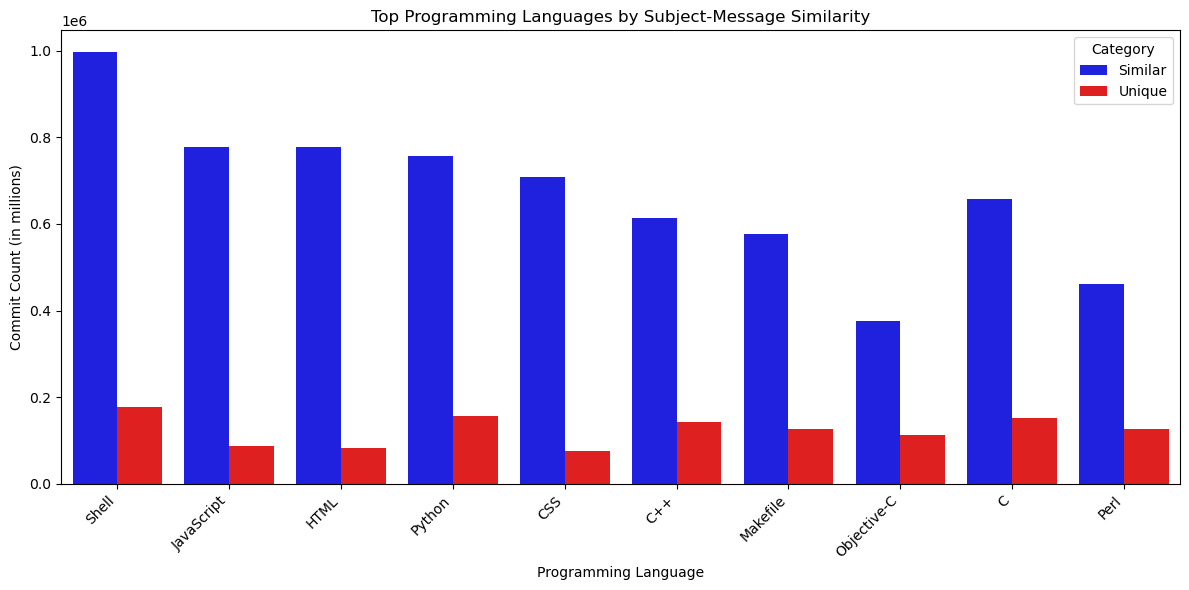

In [25]:
# Same threshold
jaccard_threshold = 0.7

# Extract first element from repo_name array and create is_similar column
similarity_sample_fixed = (
    similarity_sample
    .withColumn("repo_name", col("repo_name").getItem(0))
    .withColumn("distCol", 1 - col("jaccard_similarity"))
    .withColumn(
        "is_similar",
        when(col("distCol") < jaccard_threshold, True).otherwise(False) 
    )
)

# Join the language and similarity dfs
language_similarity = exploded_languages.join(
    similarity_sample_fixed,
    on="repo_name",
    how="inner"
)

# Group by language and similarity category, count occurrences
language_counts = language_similarity.groupBy(
    "exploded_language_name",
    "is_similar"
).agg(
    count("*").alias("commit_count")
).toPandas()

# Create more readable category names
language_counts['category'] = language_counts['is_similar'].map({True: 'Similar', False: 'Unique'})

# Get top 10 languages by total commit count
N = 10
top_languages = (
    language_counts.groupby('exploded_language_name')['commit_count']
    .sum()
    .sort_values(ascending=False)
    .head(N)
    .index
)

# Filter for top languages
plot_data = language_counts[language_counts['exploded_language_name'].isin(top_languages)]

# Create the visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data,
    x='exploded_language_name',
    y='commit_count',
    hue='category',
    palette={'Similar': 'blue', 'Unique': 'red'}
)

plt.title('Top Programming Languages by Subject-Message Similarity')
plt.xlabel('Programming Language')
plt.ylabel('Commit Count (in millions)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category')
plt.tight_layout()

# Display the plot
plt.show()

/tmp/ipykernel_12732/1502108531.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.1f}M'.format(x/1_000_000) for x in current_values])


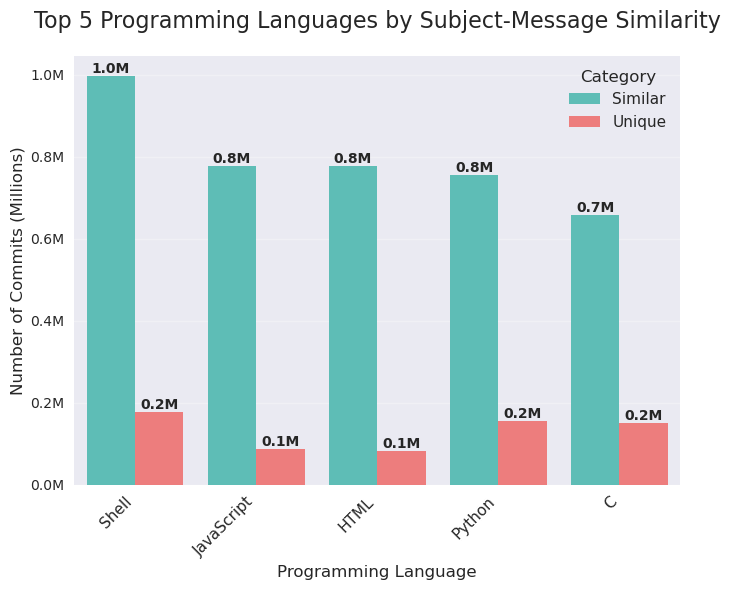

In [38]:
plt.style.use('seaborn')

# Get top 5 languages by total commit count
N = 5
top_languages = (
    language_counts.groupby('exploded_language_name')['commit_count']
    .sum()
    .sort_values(ascending=False)
    .head(N)
    .index
)

# Filter for top languages
plot_data = language_counts[language_counts['exploded_language_name'].isin(top_languages)]

plt.figure(figsize=(7, 6))

bars = sns.barplot(
    data=plot_data,
    x='exploded_language_name',
    y='commit_count',
    hue='category',
    palette={'Similar': '#4ECDC4', 'Unique': '#FF6B6B'}  # Turquoise and coral red
)

# Add value labels on the bars
for p in bars.patches:
    # Format height in millions with one decimal place
    height_in_millions = p.get_height() / 1_000_000
    bars.text(
        p.get_x() + p.get_width()/2.,
        p.get_height(),
        f'{height_in_millions:.1f}M',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.title('Top 5 Programming Languages by Subject-Message Similarity', 
          fontsize=16, 
          pad=20)
plt.xlabel('Programming Language', fontsize=12)
plt.ylabel('Number of Commits (Millions)', fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=10)

# Format y-axis in millions
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.1f}M'.format(x/1_000_000) for x in current_values])

plt.legend(
    title='Category',
    title_fontsize=12,
    fontsize=11,
    loc='upper right',
    framealpha=0.9,
    edgecolor='white'
)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Conclusions about AI Solutions**

Text similarity analysis reveals an extremely high proportion of similar commit messages. Thus, these commits are likely automated, which is why they may have efficient workflows but lack individuality and creativity.

The prevalence of highly-active infrastructure repositories like Docker and Linux demonstrates that modern software development is increasingly focused on complex system architectures and containerization, which requires human expertise in designing scalable, maintainable systems. This suggests that while AI may excel at generating code, the higher-level challenges of system design, infrastructure decisions, and architectural trade-offs will continue to require human decision-making. 

**Actionable Recommendations**

**Automate repetitive tasks**: Utilize AI tools to handle routine tasks such as dependency updates, deployment logs, and commit message standardization to save time and reduce errors

**Enhance collaboration instead of replacement**: Position AI as a collaborative assistant for tasks like code reviews, debugging, and workflow optimization, with final oversight from human engineers.

**Focus on human strategic roles**: Encourage developers to focus on creative problem-solving, system design, and ethical considerations where AI falls short.